# MIE 1517 Progress Report - Team 9

## 1. Introduction

This project aims to enhance workplace safety in industrial and construction environments through a real-time moitoring system. The system will leverage advanded computer vision techniques, like YOLO, to ensure that workers are wearing personal protective equipment (PPE) and staying safe around hazardous tools and areas.
The project has the following three phases planned:
1. PPE Detection
2. PPE Compliance Verification
3. Hazard Zone Detection and Proximity Alert System

### Work Flow

<img src="./Presentation/agentflow diagram.png">

# System Overview

1. The workflow begins with an **image frame** input, typically sourced from a camera. This frame is processed by **YOLOv11**, which performs two key tasks: **object detection** (identifying persons and PPE elements like helmets or vests) and **pose estimation** (identifying keypoints on the human body). The output includes the location and classification of detected objects, along with pose information.

2. Next, the system generates a **normalized depth map** using **MiDaS**, a state-of-the-art depth estimation model. MiDaS uses an encoder-decoder architecture (e.g., a BEiT Encoder followed by a Decoder) to produce a relative depth map from a single RGB frame. However, this depth map is not in real-world units.

3. To address this, a **calibration** step is performed. The system detects a known reference marker, such as an **AprilTag**, placed at a known distance from the camera. By comparing the AprilTag’s real-world depth to the MiDaS-generated normalized depth values, a **real depth conversion factor** is calculated. Applying this factor transforms the normalized depth map into approximate real distances. After that, Key points extracted from YOLO pose will be used to determine the depth of target.

4. Finally, the **compliance check** examines whether the detected person is wearing the required PPE and is outside of a defined “danger zone.” If someone is within a hazardous distance without proper PPE, the system triggers an **alarm** as a warning.


## 2. Data Collection

- **Data Source**:
    - We used the ["PPE Detection" dataset](https://universe.roboflow.com/ai-project-yolo/ppe-detection-q897z) available on Roboflow Universe, which contains labeled images for training YOLO-based object detection models.
- **Data Description**:
    - The dataset includes images labeled for detecting person and various types of PPE such as helmets, vests, gloves. These labels are essential for training the model to identify PPE usage.
    - **Data Format**: The images and annotations are formatted for YOLO, allowing direct integration with our model pipeline.
    - **Dataset Split**:
        - **Training Set**: 82% of the dataset, with 1,153 images.
        - **Validation Set**: 11% of the dataset, with 161 images.
        - **Test Set**: 7% of the dataset, with 96 images.
    - **Label Distribution**:
        - Person: 3,107 instances
        - Helmet: 2,057 instances
        - No Vest: 1,708 instances
        - Vest: 1,288 instances (Under represented)
        - No Helmet: 983 instances (Under represented)
    - This label distribution shows that some classes, such as "No Helmet" and "Vest," are under represented. This may introduce challenges in achieving balanced detection performance across all PPE types.


### Loading Data

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Sj73sOlgWZ0H0AoSX1mk")
project = rf.workspace("ai-project-yolo").project("ppe-detection-q897z")
version = project.version(25)
dataset = version.download("yolov11")
                

### Brief Visualization

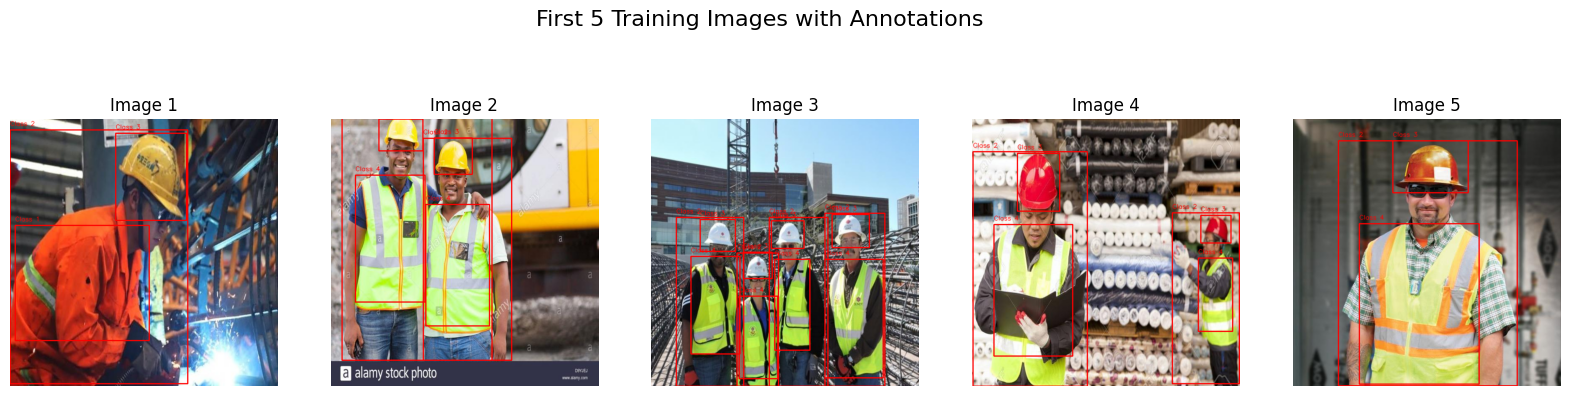

In [1]:
import cv2
import matplotlib.pyplot as plt
import os

image_path = "../dataset/ppe/train/images"
label_path = "../dataset/ppe/train/labels"

# Function to plot images with bounding boxes
def load_image_with_labels(image_file):
    # Load image
    img = cv2.imread(os.path.join(image_path, image_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Load corresponding label file
    label_file = image_file.replace(".jpg", ".txt")
    label_file_path = os.path.join(label_path, label_file)

    if os.path.exists(label_file_path):
        # Read label data and draw bounding boxes
        with open(label_file_path, "r") as f:
            for line in f:
                # Parse YOLO format (class x_center y_center width height)
                parts = line.strip().split()
                class_id, x_center, y_center, width, height = map(float, parts)

                # Convert YOLO format to bounding box coordinates
                img_h, img_w = img.shape[:2]
                x_center, y_center, width, height = (
                    x_center * img_w, y_center * img_h, width * img_w, height * img_h
                )
                x1, y1 = int(x_center - width / 2), int(y_center - height / 2)
                x2, y2 = int(x_center + width / 2), int(y_center + height / 2)

                # Draw the bounding box
                cv2.rectangle(img, (x1, y1), (x2, y2), color=(255, 0, 0), thickness=2)
                cv2.putText(img, f"Class {int(class_id)}", (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
    return img

# Get the list of image files and select the first five

image_files = [f for f in os.listdir(image_path) if f.endswith(".jpg")]
first_five_images = image_files[:5]

# Plot the first five images with labels in a single subplot
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
fig.suptitle("First 5 Training Images with Annotations", fontsize=16)

for i, image_file in enumerate(first_five_images):
    img = load_image_with_labels(image_file)
    axs[i].imshow(img)
    axs[i].axis("off")
    axs[i].set_title(f"Image {i+1}")

plt.show()

## 3. Models

### YOLO11s


#### **Training**

In [ ]:
from ultralytics import YOLO
import torch

# Load the pretrained YOLO11s model
model = YOLO("yolo11s.pt")  # pretrained yolo11s

# Path to the dataset configuration file
data_yaml_path = '../dataset/ppe/data.yaml'

# Set the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the model on your custom dataset
results = model.train(
    data=data_yaml_path,   # Path to the dataset YAML file
    epochs=300,            # Number of epochs to train
    imgsz=640,             # Input image size
    batch=32,              # Batch size
    device=device,         # Device for training
    lr0=0.01,              # Initial learning rate (adjust as needed)
    optimizer="SGD",       # Optimizer type (SGD or Adam)
    augment=True           # Enable data augmentation
)

# Print the results
print("Training completed. Results:", results)


![alt text](../runs/detect/train17/results.png)

#### **Result**


#### Model Summary
YOLO11s, with 319 layers and 9,429,727 parameters**, is relatively lightweight. At 6.3 GFLOPs, it’s computationally efficient and suitable for faster inference on limited hardware while maintaining high accuracy.


#### Overall Detection Performance


- **Training**: The model achieves high AUC Score of **0.965**, reflecting strong performance in detecting objects during training.
- **Testing**: The testing results demonstrate the model's ability to generalize, with slightly lower AUC Score of **0.842**, but still indicate reliable performance on unseen data.

---

#### Class-specific Performance

- Training: 
  - Strong precision and recall scores across most classes, with the exception of **No Helmet**, which has an accuracy of **0.84**.
  - This indicates that while the model is accurate, it struggles slightly with detecting instances of missing helmets.

- Testing:
  - Performance trends remain consistent with training results, though precision and recall are slightly lower across all classes.
  - **No Helmet** detection continues to be a challenge, with an accuracy of **0.71**, while other classes like **Person**, **Helmet**, and **Vest** perform well on unseen data.

---

#### Insights
1. Training vs. Testing Performance:
   - The drop in performance from training to testing is minor, highlighting good generalization.
   - Classes like **No Helmet** and **No Vest** exhibit relatively larger performance gaps, indicating a need for further refinement in these categories.

2. AUC Curves:
   - Most AUC curves for both training and testing datasets approach the top-right corner, reflecting strong overall performance.
   - The **No Helmet** class exhibits a lower AUC curve, showing room for improvement in detecting this category.

3. Focus on Recall:
   - Recall is critical for this application to ensure that every safety violation is detected, minimizing risks.

4. Real-world Examples:
   - The model performs well in real-world scenarios, handling complex cases like overlapping individuals and distinguishing PPE from similar non-PPE items (e.g., differentiating PPE helmets from ski helmets).

---

#### Conclusion
The YOLO11s model demonstrates strong performance in detecting PPE compliance, with high precision and recall across training and testing datasets. While it generalizes well, improvements are needed for **No Helmet** detection, which can be addressed with targeted data augmentation and compliance methods. Overall, the model is effective for real-world safety monitoring applications, ensuring critical safety violations are identified reliably.


                                                                 Training Set                                                                               

<div style="display: flex; justify-content: space-around;">
  <img src="../runs/detect/train17/PR_curve.png" alt="PR Curve" width="45%">
  <img src="../runs/detect/train17/confusion_matrix_normalized.png" alt="Confusion Matrix" width="45%">
</div>


                                                                 Testing Set                                                                               

<div style="display: flex; justify-content: space-around;">
  <img src="../runs/detect/val7/PR_curve.png" alt="PR Curve" width="45%">
  <img src="../runs/detect/val7/confusion_matrix_normalized.png" alt="Confusion Matrix" width="45%">
</div>

#### **Some Examples**
<div style="display: flex; justify-content: space-around;">
  <img src="../runs/detect/train17/val_batch0_pred.jpg" alt="Example 1" width="48%">
  <img src="../runs/detect/train17/val_batch1_pred.jpg" alt="Example 2" width="48%">
</div>


### PPE Compliance Check


image 1/1 C:\Users\wwr01\OneDrive\Desktop\GRAD\MIE1517\Project\input\009a716f953692ba_jpg.rf.fc74d06060acfcb480e49a418a221ce8.jpg: 640x640 1 No helmet, 1 No vest, 1 Person, 8.0ms
Speed: 2.0ms preprocess, 8.0ms inference, 64.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\wwr01\OneDrive\Desktop\GRAD\MIE1517\Project\input\07-25-2021T02034028ee52121b596_jpg.rf.eaa4ca3d7f98f1a255007dd21e0fc1af.jpg: 384x640 4 No helmets, 4 No vests, 4 Persons, 32.9ms
Speed: 2.0ms preprocess, 32.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 C:\Users\wwr01\OneDrive\Desktop\GRAD\MIE1517\Project\input\ppe_0038_png_jpg.rf.c34b5b86fb4d3ab072ffd3d9bd8674bb.jpg: 640x640 1 No vest, 4 Persons, 4 helmets, 3 vests, 9.0ms
Speed: 2.0ms preprocess, 9.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Users\wwr01\OneDrive\Desktop\GRAD\MIE1517\Project\input\ppe_0259_png_jpg.rf.81fc1f8f11c0c9c5695c6386307a8da2.jpg: 640x640 2 No vests, 

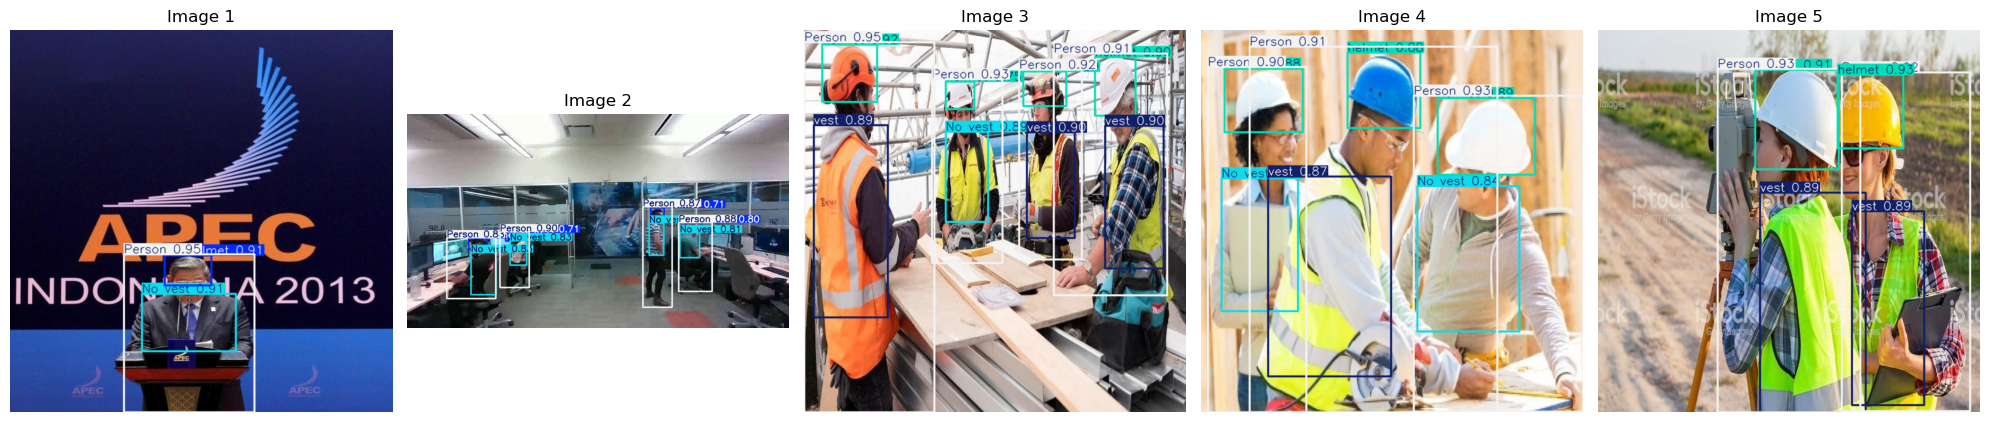

In [1]:
from ultralytics import YOLO
from IPython.display import display, clear_output
from pathlib import Path
import matplotlib.pyplot as plt

image_path_test = r'C:\Users\wwr01\OneDrive\Desktop\GRAD\MIE1517\Project\input'
model_path = r'C:\Users\wwr01\OneDrive\Desktop\GRAD\MIE1517\Project\Models\yolo11n-ppe-1111.pt'

clear_output(wait=True)
model = YOLO(model_path)  # Path to the best model weights

test_images_path = Path(image_path_test)

test_images = list(test_images_path.glob("*.jpg"))

test_images = test_images[:5]

fig, axs = plt.subplots(1, len(test_images), figsize=(20, 5))

results_list=[]
image_list=[]

for i, image_path in enumerate(test_images):
    image_list.append(image_path)
    results = model(image_path)
    results_list.append(results)
    annotated_img = results[0].plot()
    annotated_img_rgb = annotated_img[:, :, ::-1]
    axs[i].imshow(annotated_img_rgb)
    axs[i].axis("off")
    axs[i].set_title(f"Image {i+1}")

plt.tight_layout()
plt.show()

The compliance check function utilizes the "has_overlap function" which checks if a detected - person's bounding box sufficiently overlaps with any of the bounding boxes for items like helmets or vests*
  - It calculates the intersection area between the person and item boxes and compares this area to the item's area to get an overlap ratio.
  - If the overlap ratio meets or exceeds a specified threshold, it returns True, indicating sufficient overlap; otherwise, it returns False.
  - This logic helps determine if PPE items are positioned correctly on the person for compliance verification.

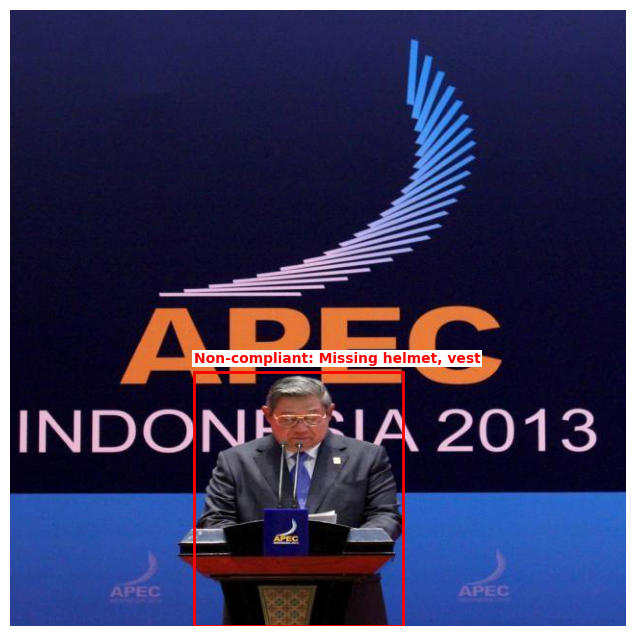

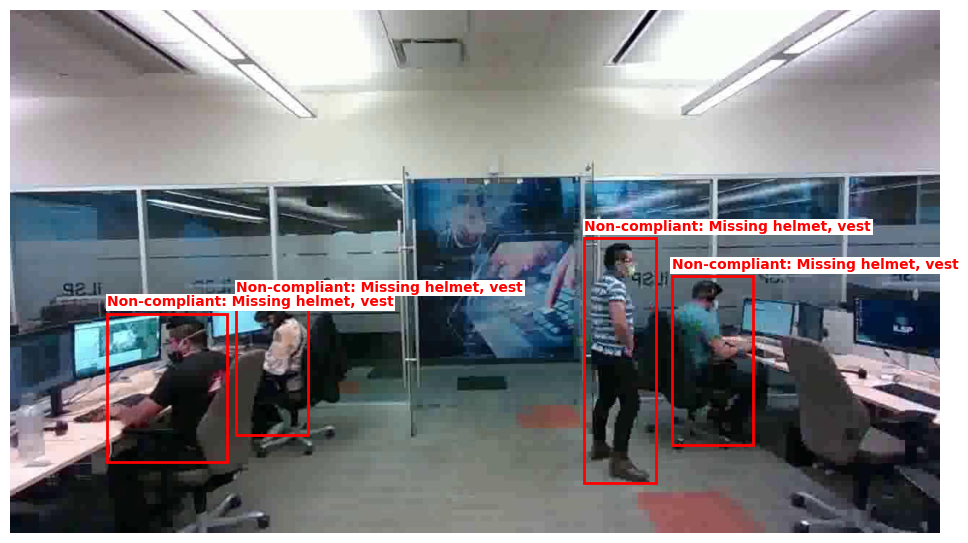

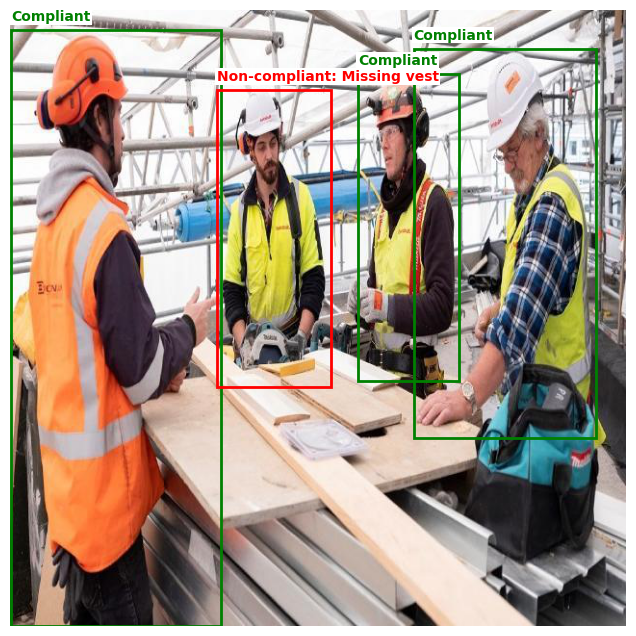

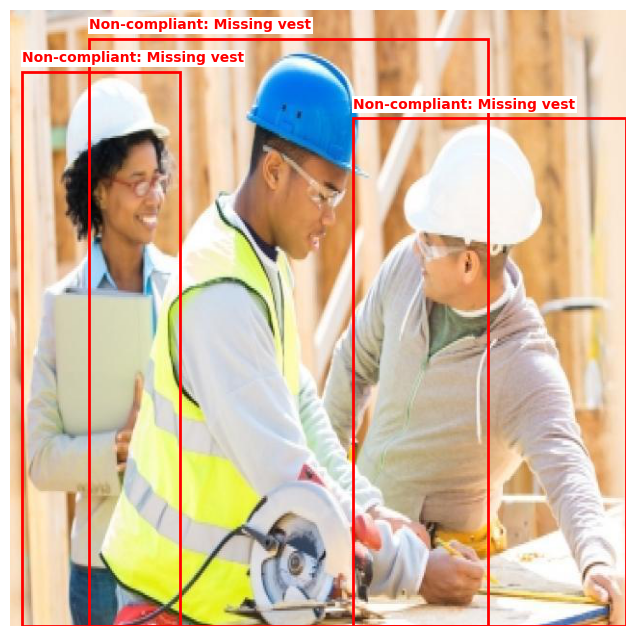

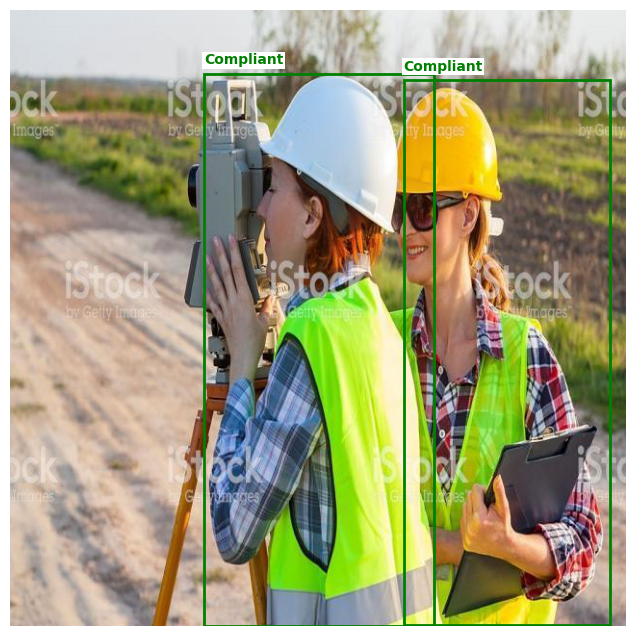

In [11]:
# Sample Code to check the PPE compliance based on the model predictions
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
for results, image_path in zip(results_list, image_list):
  # Add Detections
  detections = results[0].boxes.data.tolist()

  # Define classes, subject to change
  NO_HELMET_CLASS = 0.0
  NO_VEST_CLASS = 1.0
  PERSON_CLASS = 2.0
  HELMET_CLASS = 3.0
  VEST_CLASS = 4.0

  # Define confidence threshold
  confidence_threshold = 0.8

  # Separate detections by class with confidence filtering
  people_detections = [det for det in detections if det[5] == PERSON_CLASS and det[4] >= confidence_threshold]
  helmet_detections = [det for det in detections if det[5] == HELMET_CLASS and det[4] >= confidence_threshold]
  vest_detections = [det for det in detections if det[5] == VEST_CLASS and det[4] >= confidence_threshold]
  no_helmet_detections = [det for det in detections if det[5] == NO_HELMET_CLASS]
  no_vest_detections = [det for det in detections if det[5] == NO_VEST_CLASS]

  # Function to check if a detected item overlaps with a person based on bounding box coordinates
  def has_overlap(person_box, item_boxes, overlap_threshold=0.1):
      px_min, py_min, px_max, py_max = person_box[:4]

      for item_box in item_boxes:
          ix_min, iy_min, ix_max, iy_max = item_box[:4]

          # Calculate intersection coordinates
          inter_x_min = max(px_min, ix_min)
          inter_y_min = max(py_min, iy_min)
          inter_x_max = min(px_max, ix_max)
          inter_y_max = min(py_max, iy_max)

          # Calculate areas
          inter_area = max(0, inter_x_max - inter_x_min) * max(0, inter_y_max - inter_y_min)
          item_area = (ix_max - ix_min) * (iy_max - iy_min)

          # Calculate overlap ratio
          overlap_ratio = inter_area / item_area

          # Check if the overlap is above the threshold
          if overlap_ratio >= overlap_threshold:
              return True  # Sufficient overlap found

      return False  # No item met the overlap threshold

  # Check PPE compliance and prepare labels for display
  compliance_results = []
  for i, person in enumerate(people_detections, start=1):
      # Check for required and missing PPE
      has_helmet = has_overlap(person, helmet_detections)
      has_vest = has_overlap(person, vest_detections)
      no_helmet = has_overlap(person, no_helmet_detections)
      no_vest = has_overlap(person, no_vest_detections)

      # Determine compliance status
      missing_items = []
      if no_helmet:
          missing_items.append("helmet")
      if no_vest:
          missing_items.append("vest")

      if missing_items:
          compliance_status = "Non-compliant"
          compliance_label = f"Non-compliant: Missing {', '.join(missing_items)}"
      elif has_helmet and has_vest:
          compliance_status = "Compliant"
          compliance_label = "Compliant"
      else:
          if not has_helmet:
              missing_items.append("helmet")
          if not has_vest:
              missing_items.append("vest")
          compliance_status = "Non-compliant"
          compliance_label = f"Non-compliant: Missing {', '.join(missing_items)}"

      # Store the bounding box coordinates and compliance label
      compliance_results.append((person[:4], compliance_status, compliance_label))
  # Load the original image
  image = Image.open(image_path)

  # Create a figure and axis to display the image
  fig, ax = plt.subplots(1, figsize=(12, 8))
  ax.imshow(image)

  if not people_detections:
        plt.text(0.5, 0.5, "No person detected", color='red', fontsize=20, fontweight='bold',
                 ha='center', va='center', transform=ax.transAxes, backgroundcolor="white")
  else:
        # Draw bounding boxes and labels on the image
        for (bbox, compliance_status, compliance_label) in compliance_results:
            px_min, py_min, px_max, py_max = bbox

            # Draw bounding box
            rect = patches.Rectangle((px_min, py_min), px_max - px_min, py_max - py_min,
                                     linewidth=2, edgecolor='green' if compliance_status == "Compliant" else 'red', facecolor='none')
            ax.add_patch(rect)
            # Add label directly above the bounding box
            plt.text(px_min, py_min - 10, compliance_label, color='green' if compliance_status == "Compliant" else 'red',
                     fontsize=10, fontweight='bold', backgroundcolor="white", bbox=dict(facecolor="white", edgecolor="none", pad=1))
  # Display the result
  plt.axis('off')
  plt.show()

### **Second Model: MiDaS - Monocular Depth Estimation**

We utilized a **pre-trained MiDaS model** to generate relative normalized depth maps. The following steps summarize the process and results:

1. **Calibration with QR Codes**:
   - Two QR codes with known real-world distances were used to calibrate the relative depth map into a real-world depth map by measuring their proportional norm.
   - **Result**: The calibration process produced a mean absolute error (MAE) of **1.3 meters**, which is acceptable for monocular depth estimation.

2. **Performance Comparison**:
   The following table compares the MiDaS estimated depths to the ground truth values:
   
   | **Name** | **MiDaS Estimated Depths (m)** | **Ground Truth Depths (m)** |
   |----------|--------------------------------|-----------------------------|
   | Tag 0    | 4.9                            | 3.4                         |
   | Tag 1    | 3.6                            | 2.5                         |

3. **Challenges in Depth Estimation**:
   - Depth variability occurs in different body parts of a person, leading to inconsistent depth measurements.

4. **Enhancement with YOLO Pose Estimation**:
   - We applied YOLO pose estimation to extract a few **keypoints** from the detected person (e.g., shoulders, knees).
   - The **average depth** of these keypoints was computed as a more reliable estimate of the overall depth of the person.

5. **Processing Time**:
   - The process is computationally expensive, taking approximately **1–1.5 seconds per frame** due to the additional steps of depth calibration and keypoint-based refinement.

---

This method improves the reliability of monocular depth estimation by incorporating pose-based refinement, although further optimization is needed to reduce processing time for real-time applications.




<div style="display: flex; justify-content: center; gap: 10px; align-items: center;">
  <img src="../Presentation/depthmapdiagram.png" alt="Depth Map" style="width: 18%; height: auto;">
  <img src="../Presentation/depthmap.png" alt="Depth Map Diagram" style="width: 25%; height: auto;">
</div>


/home/home/school/MIE1517/mie1517_project/scripts/midas/base_model.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  parameters = torch.load(path, map_location=torch.devi

Model loaded, number of parameters = 345M
[PosixPath('../dataset/Safety-6/valid/images/Video4_272_jpg.rf.02a2acc82f87b49e1542edcfc0cd7d35.jpg'), PosixPath('../dataset/Safety-6/valid/images/Video4_30_jpg.rf.9e983ac6c0026272ceba26bc48ca8f39.jpg'), PosixPath('../dataset/Safety-6/valid/images/AightDuo0294_jpg.rf.84dc7eed6e275262009fa354ef937885.jpg'), PosixPath('../dataset/Safety-6/valid/images/Video4_281_jpg.rf.f82866e43a22a4b64d101019b96f7053.jpg'), PosixPath('../dataset/Safety-6/valid/images/Video4_45_jpg.rf.527a05e31d5a1a3efd115c79233711ba.jpg')]
    Input resized to 512x512 before entering the encoder
    Input resized to 512x512 before entering the encoder
    Input resized to 512x512 before entering the encoder
    Input resized to 512x512 before entering the encoder
    Input resized to 512x512 before entering the encoder


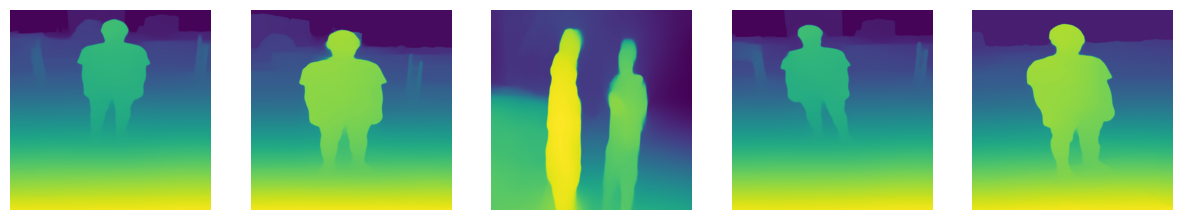

In [ ]:
# Sample Code to predict the depth map of the image using Midas
import sys
from pathlib import Path
import numpy as np

# Add the project directory to the Python path
sys.path.insert(1, '..')

from scripts.midas_core import MidasCore

# Load the MiDaS model
midas_model_path = '../checkpoints/dpt_beit_large_512.pt'
midas = MidasCore(midas_model_path)

# Lod the input image
test_images_path = Path('../dataset/Safety-6/valid/images')
test_images = list(test_images_path.glob("*.jpg"))


# Process each image to obtain depth maps and apply color mapping
depth_maps = [midas.get_depth(image) for image in test_images[:5]]
colored_depth_maps = [cv2.applyColorMap(np.uint8(depth_map), cv2.COLORMAP_VIRIDIS) for depth_map in depth_maps]

# Plot the depth maps in a single figure with 5 subplots
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, ax in enumerate(axes):
    # Convert BGR (OpenCV format) to RGB for Matplotlib
    ax.imshow(cv2.cvtColor(colored_depth_maps[i], cv2.COLOR_BGR2RGB))
    ax.axis("off")

plt.show()

## 5. Feasibility and Next Steps

Our project aim to achieve real-time PPE object detection and evaluate whether workers are wearing PPE correctly and incorporate distance estimation to monitor their proximity to hazardous and dangerous tools and areas. If a worker is detected near dangerous construction sites or equipment without PPE compliance, the system will automatically trigger an alert, providing a timely warning to prevent accidents and enhance overall site safety.

By far, a YOLOv11n model has already been trained on our custom dataset, demonstrating successful identification of specific PPE items (helmet, vest) and their absence (no helmet, no vest), along with persons. And a rule-based algorithm will be applied based on the bounding box generated by the model. As shown above it is functional, correctly evaluating PPE compliance and visually labeling individuals as compliant or non-compliant. The existing functionality forms a solid foundation for finalizing the project’s core requirements. 


The MiDaS model effectively captures depth information from the images, producing a color-coded depth representation. We selected MiDaS for its high accuracy and ease of integration, making it an ideal choice for depth estimation in our project. This model enables precise distance measurement between workers and the camera with minimal setup, enhancing our ability to monitor spatial positioning efficiently.
<br><br>

**Remaining Tasks:**
* To achieve higher accuracy on PPE detection, a larger model would be essential. While the YOLOv11n model has demonstrated satisfactory performance, its smaller size limits its ability to capture finer details and complex patterns in the data. We might use YOLOv11l or YOLOv11x to better capture the nuanced features, which lead to more accurate PPE detection and compliance check.

* Although the compliance checking algorithm is functional, mannually establishing these rules for multiple PPEs might be inaccurate when situatiions get complicated. We may consider using some machine learning algorithms such as neural network and decision tree to implicitily learn such rules and automatically chek the person's PPE compliance. This process can be chanleenging, and costly. (Optional, may ask for further approvement from professor)

* We plan to integrate depth estimation to assess the distance between workers and the machine. This will allow us to detect proximity violations and ensure worker safety.

* To refine depth accuracy, we will also incorporate YOLO pose estimation to identify keypoints on the workers’ bodies, such as shoulders, head, and torso. By calculating the mean depth of these keypoints, we aim to achieve a more precise measure of each worker’s distance from the machine.

* If time permits, we may explore switching to a more trainable, self-supervised depth model to enhance control and customization.

* Currently, our model processes static images. A key remaining task is to enable real-time video input, allowing the model to monitor workers continuously.
<br><br>

**Timeline:**
* **Improve Model Capability:** Train a YOLOv11l model on our dataset within this week.
* **Depth and Pose Integration:** Complete MiDaS and YOLO pose integration for depth estimation on static images within this week.

* **Video Input Setup:** Transition to video input processing in the second week, with real-time testing and optimization to ensure the model can handle continuous monitoring.

* **Final Testing and Optimization:** Reserve the last phase for refining model performance with video input and, if feasible, consider alternative depth models for further customization.